In [130]:
# Importing Dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import keras_tuner as kt

In [131]:
# Importing data
conn = sqlite3.connect('data.db')
churn_data = pd.read_sql_query("SELECT * FROM data", conn)
conn.close()
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [132]:
# Dropping non-essential columns in reference to churn potential
churn_data = churn_data.drop(["RowNumber", "CustomerId", "Surname", "Geography"], axis=1)
churn_data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,516,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,709,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,772,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


In [133]:
# Designating bins to group credit scores
bins = [299, 579, 669, 739, 799, 850]
churn_data["CreditScore"] = pd.cut(churn_data["CreditScore"], bins=bins, labels=["300-579", "580-669", "670-739", "740-799", "800-850"])

# Checking if binning was successful
churn_data["CreditScore"].value_counts()

CreditScore
580-669    3331
670-739    2428
300-579    2362
740-799    1224
800-850     655
Name: count, dtype: int64

In [134]:
bins = [0, 25000, 50000, 75000, 100000, 125000, 900000]
churn_data["EstimatedSalary"] = pd.cut(churn_data["EstimatedSalary"], bins=bins, labels=["0-25k", "25k-50k", "50k-75k", "75k-100k", "100k-125k", "125k+"])
churn_data["EstimatedSalary"].value_counts()

EstimatedSalary
125k+        3734
100k-125k    1276
50k-75k      1269
75k-100k     1268
25k-50k      1236
0-25k        1217
Name: count, dtype: int64

In [135]:
bins = [0, 25000, 50000, 75000, 100000, 125000, 900000]
churn_data["Balance"] = pd.cut(churn_data["Balance"], bins=bins, labels=["0-25k", "25k-50k", "50k-75k", "75k-100k", "100k-125k", "125k+"])
churn_data["Balance"].value_counts()

Balance
125k+        2731
100k-125k    2068
75k-100k     1160
50k-75k       349
25k-50k        69
0-25k           6
Name: count, dtype: int64

In [136]:
bins = [0, 20, 40, 60, 80, 200]
churn_data["Age"] = pd.cut(churn_data["Age"], bins=bins, labels=["0-20", "20-40", "40-60", "60-80", "80+"])
churn_data["Age"].value_counts()

Age
20-40    6330
40-60    3117
60-80     452
0-20       89
80+        12
Name: count, dtype: int64

In [137]:
# Converting categorical data to numeric with "pd.get_dummies"
numerics = pd.get_dummies(churn_data)
numerics

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned,CreditScore_300-579,CreditScore_580-669,...,EstimatedSalary_0-25k,EstimatedSalary_25k-50k,EstimatedSalary_50k-75k,EstimatedSalary_75k-100k,EstimatedSalary_100k-125k,EstimatedSalary_125k+,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,2,1,1,1,1,1,2,464,False,True,...,False,False,False,False,True,False,True,False,False,False
1,1,1,0,1,0,1,3,456,False,True,...,False,False,False,False,True,False,True,False,False,False
2,8,3,1,0,1,1,3,377,True,False,...,False,False,False,False,True,False,True,False,False,False
3,1,2,0,0,0,0,5,350,False,False,...,False,False,False,True,False,False,False,True,False,False
4,2,1,1,1,0,0,5,425,False,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,2,1,0,0,0,1,300,False,False,...,False,False,False,True,False,False,True,False,False,False
9996,10,1,1,1,0,0,5,771,True,False,...,False,False,False,False,True,False,False,False,True,False
9997,7,1,0,1,1,1,3,564,False,False,...,False,True,False,False,False,False,False,False,False,True
9998,3,2,1,0,1,1,2,339,False,False,...,False,False,False,True,False,False,False,True,False,False


In [138]:
# Splitting preprocessed data into featured and target arrays
y = numerics["Exited"].values
x = numerics.drop("Exited", axis = 1).values

# Getting the training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [139]:
# Creating StandardScaler instances
scaler = StandardScaler()

# Fitting StandardScaler
x_scaler = scaler.fit(x_train)

# Scaling data
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [140]:
#Determine number of input features
input_features = x_train_scaled.shape[1]
input_features

35

In [141]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value= 90,
        step=5), activation=activation, input_dim=input_features))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [142]:
# Define a global list to store accuracies
accuracies_list = []

# Define a custom callback to log accuracy after each trial
class AccuracyLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(AccuracyLogger, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        #Debug
#         print(f"Epoch {epoch+1} - Validation Accuracy: {val_accuracy}")
        accuracies_list.append(val_accuracy)
        #Debug
#         print("Accuracies list:", accuracies_list)

In [143]:
# Initialize Keras Tuner
tuner = RandomSearch(
    create_model,  # Define your model builder function here
    objective='val_accuracy',
    max_trials=10,  # Specify the number of trials
    project_name='KerasTuner_Churn')

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.9987999796867371

Best val_accuracy So Far: 0.9987999796867371
Total elapsed time: 00h 02m 07s


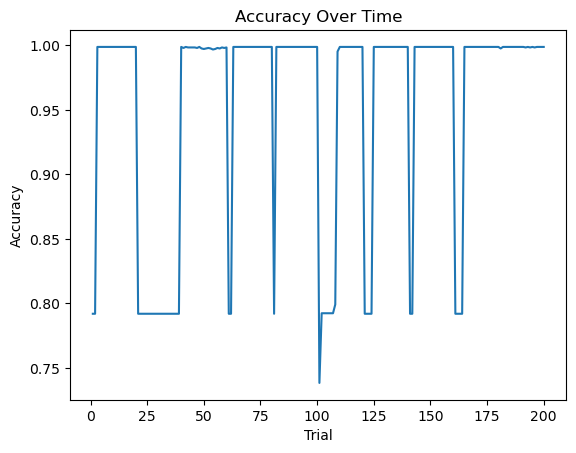

In [144]:
# Initialize the custom callback
accuracy_logger = AccuracyLogger()

# Start the search process
tuner.search(
    x_train_scaled,
    y_train,
    epochs=20,
    validation_data=(x_test_scaled, y_test),
    callbacks=[accuracy_logger])

# Plot accuracy over time
plt.plot(np.arange(1, len(accuracies_list) + 1), accuracies_list)
plt.xlabel('Trial')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.show()

In [145]:
# Top 3 model hyperparameters 
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 81, 'num_layers': 4, 'units_0': 1, 'units_1': 1, 'units_2': 1, 'units_3': 1}
{'activation': 'sigmoid', 'first_units': 1, 'num_layers': 5, 'units_0': 16, 'units_1': 6, 'units_2': 26, 'units_3': 26, 'units_4': 1}
{'activation': 'tanh', 'first_units': 11, 'num_layers': 3, 'units_0': 6, 'units_1': 26, 'units_2': 11, 'units_3': 16, 'units_4': 26}


In [146]:
# Top 3 models
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(x_test_scaled,y_test,verbose=2)
    print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
C:\Users\domin\anaconda3\envs\dev\lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


79/79 - 0s - 5ms/step - accuracy: 0.9988 - loss: 0.3142
Loss: 0.31422457098960876, Accuracy: 0.9987999796867371
79/79 - 0s - 5ms/step - accuracy: 0.9988 - loss: 0.2065
Loss: 0.20651845633983612, Accuracy: 0.9987999796867371
79/79 - 0s - 4ms/step - accuracy: 0.9988 - loss: 0.0107
Loss: 0.010650443844497204, Accuracy: 0.9987999796867371


In [147]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters()[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 81,
 'num_layers': 4,
 'units_0': 1,
 'units_1': 1,
 'units_2': 1,
 'units_3': 1}

In [148]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(x_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

79/79 - 0s - 5ms/step - accuracy: 0.9988 - loss: 0.3142
Loss: 0.31422457098960876, Accuracy: 0.9987999796867371
